# **Neuropolis-X1**
### **Building an artificial intelligence system for human brain activity prediction (EEG, fMRI) with machine learning, deep learning, and large language models**

#### Maël Donoso, Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/)
*18th March 2025*

This first extension (X1) of Neuropolis includes twelve Notebooks:

*01: fMRI Preprocessing*

*02: EEG Preprocessing*

*03: Classification Models*

*04: Regression Models*

*05: Neural Networks*

*06: Convolutional Neural Networks*

*07: Recurrent Neural Networks*

*08: Transformers*

*09: Large Language Models*

***10: Large Language Model Chain-of-Thought***

*11: Large Language Model Fine-Tuning*

*12: Large Multimodal Model*

### Notebook 10

# **Large Language Model Chain-of-Thought**

## **1. Region-Channel Mapping**

We retrieve the **region-channel mapping**, associating each brain region to the EEG channel whose signal is most likely to provide relevant information regarding its fMRI activity. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import mne
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [2]:
# Define the raw data path. 
raw_data_path = '../../Neuropolis/ds002336-download/'

# Define the preprocessed data path. 
preprocessed_data_path = '../neuropolis-x1_preprocessed_data/'

# Define the results path. 
results_path = '../neuropolis-x1_results/'

In [3]:
# Load the features and the targets for the classification task. 
with open(preprocessed_data_path + 'dict_targets.p', 'rb') as file:
    dict_targets = pickle.load(file)
with open(preprocessed_data_path + 'classification/dict_features_classification_basis.p', 'rb') as file:
    dict_features_basis_class = pickle.load(file)
with open(preprocessed_data_path + 'classification/dict_targets_classification_basis.p', 'rb') as file:
    dict_targets_basis_class = pickle.load(file)

# Load the region-channel mapping. 
with open(results_path + 'region_channel_mapping.p', 'rb') as file:
    region_channel_mapping = pickle.load(file)

In [4]:
# Define the list of subjects and an example subject. 
subjects = ['sub-xp1' + str(x).zfill(2) for x in range(1, 11)]
subject = subjects[0]

# Retrieve and display the total number of scans. 
nb_scans_total = dict_targets[subject]['eegfmriNF']['Frontal Pole'].shape[0]
nb_scans_total

200

In [5]:
# Retrieve the list of all targets. 
targets = list(dict_targets[subject]['eegfmriNF'].keys())

# Display the brain region names and the number of brain regions. 
print(targets)
print(len(targets), 'brain regions')

['Background', 'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcallosal Cortex', 'Paracingulate

In [6]:
# Define the bandpower names. 
bandpower_names = ['Delta (1-4 Hz)', 'Theta (4-8 Hz)', 'Alpha (8-12 Hz)', 'Sigma (12-16 Hz)', 'Beta (16-30 Hz)', 'Gamma (30-40 Hz)']

# Define the path of the header file (.vhdr) for this subject, for the eegfmriNF condition. 
vhdr_path = raw_data_path + 'derivatives/' + subject + '/eeg_pp/' + subject + '_task-eegfmriNF_eeg_pp.vhdr'

# Load the EEG data using the MNE library, keeping error messages but suppressing warnings. 
channels_data = mne.io.read_raw_brainvision(vhdr_path, misc = ['ECG'], preload = True, verbose = 'ERROR')

# Remove the ECG channel from the channel names. 
channel_names = channels_data.ch_names
channel_names.remove('ECG')

# Display the channel names and the number of channels. 
print(channel_names)
print(len(channel_names), 'channels')

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz', 'CPz']
63 channels


In [7]:
# Display the region-channel mapping. 
region_channel_mapping

{'Frontal Pole': 'Fpz',
 'Insular Cortex': 'T7',
 'Superior Frontal Gyrus': 'Fz',
 'Middle Frontal Gyrus': 'F3',
 'Inferior Frontal Gyrus, pars triangularis': 'F7',
 'Inferior Frontal Gyrus, pars opercularis': 'F7',
 'Precentral Gyrus': 'C3',
 'Temporal Pole': 'FT9',
 'Superior Temporal Gyrus, anterior division': 'FT7',
 'Superior Temporal Gyrus, posterior division': 'T7',
 'Middle Temporal Gyrus, anterior division': 'T7',
 'Middle Temporal Gyrus, posterior division': 'T7',
 'Middle Temporal Gyrus, temporooccipital part': 'P7',
 'Inferior Temporal Gyrus, anterior division': 'T7',
 'Inferior Temporal Gyrus, posterior division': 'P7',
 'Inferior Temporal Gyrus, temporooccipital part': 'PO7',
 'Postcentral Gyrus': 'C3',
 'Superior Parietal Lobule': 'Pz',
 'Supramarginal Gyrus, anterior division': 'CP3',
 'Supramarginal Gyrus, posterior division': 'P3',
 'Angular Gyrus': 'P3',
 'Lateral Occipital Cortex, superior division': 'PO3',
 'Lateral Occipital Cortex, inferior division': 'O1',
 'Int

## **2. Gemma Chain-of-Thought**

We use the **Gemma-2-2B-IT large language model** with a Chain-of-Thought approach, and select its hyperparameters in order to ensure a relative variety of responses. We define two prompts, one to predict cognitive functions based on EEG data, and the other to predict fMRI data based on cognitive functions. We run the large language model on the eegfmriNF condition of all subjects, for a selection of brain regions spanning both a reasonable fraction of the brain and a variety of cognitive functions. The large language model predicts the evolution of the fMRI signal with an accuracy slightly higher than the baseline. 

In [8]:
# Define the LLM to use. 
model_name = 'google/gemma-2-2b-it'

# Load the tokenizer and the model. 
tokenizer_gemma = AutoTokenizer.from_pretrained(model_name)
model_gemma = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype = torch.float16, device_map = 'auto')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# Define a function to create the first LLM prompt, from EEG to cognitive functions. 
def prompt_llm_eeg_to_cognition(X, fmri_scan_index, sequence_length, selected_bandpowers, selected_eeg_channel):

    # Retrieve the sequence of features. 
    X_sequence = X[(fmri_scan_index - sequence_length):fmri_scan_index, :]

    # Create the prompt. 
    bandpowers_results = ', '.join(
        f"{bandpower_names[bandpower_index]}: {X_sequence[:, bandpower_index]}" for bandpower_index in selected_bandpowers
    )
    prompt = (
        f"A human subject participated in a neuroscience experiment where EEG data and fMRI data were recorded simultaneously. "
        f"The EEG band powers were measured every two seconds at electrode {selected_eeg_channel}, "
        f"with the following results: {bandpowers_results}. "
        f"Given the EEG data, which cognitive functions is the subject likely engaging in? "
        f"Base your answer on your general knowledge in neuroscience and EEG research. "
        f"Please answer with only a list of cognitive functions. Just give your best prediction, without any explanation."
    )

    return prompt

In [10]:
# Define a function to create the second LLM prompt, from cognitive functions to fMRI. 
def prompt_llm_cognition_to_fmri(cognitive_functions, selected_brain_region):

    # Create the prompt. 
    prompt = (
        f"A human subject participated in a neuroscience experiment where EEG data and fMRI data were recorded simultaneously. "
        f"This subject experienced the following cognitive functions: {cognitive_functions}. "
        f"The fMRI BOLD signal was measured in the {selected_brain_region}. "
        f"Given the cognitive functions, is the fMRI signal in this brain region likely increasing or decreasing? "
        f"Base your answer on your general knowledge in neuroscience and fMRI research. "
        f"Please answer with only one word: Increasing or Decreasing. Just give your best prediction, without any explanation."
    )

    return prompt

In [11]:
# Define a function to run a LLM. 
def run_llm(prompt, tokenizer, model):

    # Run the LLM. 
    inputs = tokenizer(prompt, return_tensors = 'pt').to(model.device)
    output = model.generate(**inputs, 
                            max_new_tokens = 20, 
                            temperature = 1.2, 
                            top_p = 0.9, 
                            top_k = 50, 
                            do_sample = True, 
                            repetition_penalty = 1)

    # Decode the generated text, remove the original prompt, and return the answer. 
    generated_text = tokenizer.decode(output[0], skip_special_tokens = True)
    answer_only = generated_text[len(prompt):].strip()
    
    return answer_only

In [12]:
# Define a function to run a LLM multiple times with a Chain-of-Thought approach. 
def run_llm_series(X, Y, fmri_scans, sequence_length, selected_bandpowers, selected_eeg_channel, selected_brain_region, tokenizer, model):

    # Create the NumPy arrays to store the true values and predictions.     
    Y_true = np.zeros(len(fmri_scans))
    Y_pred = np.zeros(len(fmri_scans))
    answers_cognitive_functions = []
    answers_fmri_predictions = []
    counter = 0

    # Iterate through all selected fMRI scans. 
    for fmri_scan_index in fmri_scans:

        # Create the first LLM prompt. 
        prompt_eeg_to_cognition = prompt_llm_eeg_to_cognition(X, 
                                                              fmri_scan_index = fmri_scan_index, 
                                                              sequence_length = sequence_length, 
                                                              selected_bandpowers = selected_bandpowers, 
                                                              selected_eeg_channel = selected_eeg_channel)
        
        # Run the LLM a first time, and store the result. 
        cognitive_functions = run_llm(prompt_eeg_to_cognition, tokenizer, model)
        answers_cognitive_functions.append(cognitive_functions) # For debugging purposes. 

        # Create the second LLM prompt. 
        prompt_cognition_to_fmri = prompt_llm_cognition_to_fmri(cognitive_functions, 
                                                                selected_brain_region = selected_brain_region)
        
        # Run the LLM a second time, and store the result. 
        fmri_prediction = run_llm(prompt_cognition_to_fmri, tokenizer, model)
        answers_fmri_predictions.append(fmri_prediction) # For debugging purposes. 

        # Analyze the answer. 
        increase_detected = 'increas' in fmri_prediction.lower()
        decrease_detected = 'decreas' in fmri_prediction.lower()
        if increase_detected and not decrease_detected:
            Y_pred[counter] = 1
        elif decrease_detected and not increase_detected:
            Y_pred[counter] = 0
        else:
            Y_pred[counter] = -1

        # Store the true value.
        Y_true[counter] = Y[fmri_scan_index]

        # Increment. 
        counter += 1

    return Y_true, Y_pred

In [13]:
# Select a subject and a condition. 
subject = 'sub-xp101'
condition = 'eegfmriNF'

# Select a fMRI brain region and retrieve its corresponding EEG channel. 
selected_brain_region = 'Frontal Pole'
selected_brain_region_index = list(targets).index(selected_brain_region)
selected_eeg_channel = region_channel_mapping[selected_brain_region]
selected_eeg_channel_index = channel_names.index(selected_eeg_channel)

# Display the fMRI brain region and its corresponding EEG channel. 
print('Brain region:', selected_brain_region)
print('Brain region index:', int(selected_brain_region_index))
print('EEG channel:', selected_eeg_channel)
print('EEG channel index:', int(selected_eeg_channel_index))

Brain region: Frontal Pole
Brain region index: 1
EEG channel: Fpz
EEG channel index: 61


In [14]:
# Retrieve the features for the selected subject, condition, and EEG channel. 
X = dict_features_basis_class[subject][condition][:, (selected_eeg_channel_index * len(bandpower_names)):(selected_eeg_channel_index * len(bandpower_names)) + len(bandpower_names)]

# Retrieve the targets for the selected subject, condition, and fMRI brain region. 
Y = dict_targets_basis_class[subject][condition][:, selected_brain_region_index]

# Select the sequence length and the bandpowers. 
sequence_length = 5
selected_bandpowers = [0, 1, 2, 4]

In [15]:
# Create the first LLM prompt. 
prompt_eeg_to_cognition = prompt_llm_eeg_to_cognition(X, 
                                                      fmri_scan_index = 5, 
                                                      sequence_length = sequence_length, 
                                                      selected_bandpowers = selected_bandpowers, 
                                                      selected_eeg_channel = selected_eeg_channel)
prompt_eeg_to_cognition

'A human subject participated in a neuroscience experiment where EEG data and fMRI data were recorded simultaneously. The EEG band powers were measured every two seconds at electrode Fpz, with the following results: Delta (1-4 Hz): [-0.22278232  0.64400346  1.11835758 -1.24585523 -0.13343407], Theta (4-8 Hz): [ 0.3256324  -0.68492586 -0.96076972  0.99095653 -0.37529182], Alpha (8-12 Hz): [-0.40537466 -0.04844749 -0.69866725  0.40412502  1.11390381], Beta (16-30 Hz): [ 0.55265258 -0.03498027 -0.91193884  1.92475433  1.92719948]. Given the EEG data, which cognitive functions is the subject likely engaging in? Base your answer on your general knowledge in neuroscience and EEG research. Please answer with only a list of cognitive functions. Just give your best prediction, without any explanation.'

In [16]:
# Run the LLM, and display the result. 
cognitive_functions = run_llm(prompt_eeg_to_cognition, tokenizer_gemma, model_gemma)
cognitive_functions

'*Visual Perception*\n*Auditory Perception*\n*Working Memory*\n*Attention*'

In [17]:
# Create the second LLM prompt. 
prompt_cognition_to_fmri = prompt_llm_cognition_to_fmri(cognitive_functions, 
                                                        selected_brain_region = selected_brain_region)
prompt_cognition_to_fmri

'A human subject participated in a neuroscience experiment where EEG data and fMRI data were recorded simultaneously. This subject experienced the following cognitive functions: *Visual Perception*\n*Auditory Perception*\n*Working Memory*\n*Attention*. The fMRI BOLD signal was measured in the Frontal Pole. Given the cognitive functions, is the fMRI signal in this brain region likely increasing or decreasing? Base your answer on your general knowledge in neuroscience and fMRI research. Please answer with only one word: Increasing or Decreasing. Just give your best prediction, without any explanation.'

In [18]:
# Run the LLM, and display the result. 
fmri_prediction = run_llm(prompt_cognition_to_fmri, tokenizer_gemma, model_gemma)
fmri_prediction

'**Decreasing**\n\n\n \n \n **Explanation:** \n\n While the frontal pole'

In [19]:
# Run the LLM multiple times. 
fmri_scans = range(5, (nb_scans_total - 1), 10)
Y_true, Y_pred = run_llm_series(X, Y, fmri_scans, sequence_length, selected_bandpowers, selected_eeg_channel, selected_brain_region, tokenizer_gemma, model_gemma)

# Compute the average accuracy. 
accuracy_array = Y_pred[Y_pred != -1] == Y_true[Y_pred != -1]
accuracy_sequence = np.sum(accuracy_array) / accuracy_array.shape[0]
accuracy_sequence

0.35

In [20]:
# Select a condition and a list of brain regions. 
condition = 'eegfmriNF'
brain_regions = ['Frontal Pole', # High-order cognitive functions, but sometimes noisy EEG signal. 
                 'Precentral Gyrus', # Primary motor cortex. 
                 'Superior Temporal Gyrus, posterior division', # Auditory functions. 
                 'Superior Parietal Lobule', # Attention functions. 
                 'Occipital Pole'] # Primary visual cortex. 

# Define a Pandas DataFrame to store the accuracy. 
accuracy_summary_gemma_CoT = pd.DataFrame(columns = brain_regions)

# Iterate through all brain regions. 
for selected_brain_region in brain_regions:

    # Display the current brain region. 
    print(selected_brain_region)

    # Retrieve the EEG channel corresponding to the brain region. 
    selected_brain_region_index = list(targets).index(selected_brain_region)
    selected_eeg_channel = region_channel_mapping[selected_brain_region]
    selected_eeg_channel_index = channel_names.index(selected_eeg_channel)

    # Iterate through all subjects. 
    for subject in subjects:
        
        # Retrieve the features for the selected subject, condition, and EEG channel. 
        X = dict_features_basis_class[subject][condition][:, (selected_eeg_channel_index * len(bandpower_names)):(selected_eeg_channel_index * len(bandpower_names)) + len(bandpower_names)]

        # Retrieve the targets for the selected subject, condition, and fMRI brain region. 
        Y = dict_targets_basis_class[subject][condition][:, selected_brain_region_index]

        # Run the LLM multiple times. 
        fmri_scans = range(5, (nb_scans_total - 1), 10) # Extensive search. 
        #fmri_scans = range(5, (nb_scans_total - 1), 100) # Quick search for debugging. 
        Y_true, Y_pred = run_llm_series(X, Y, fmri_scans, sequence_length, selected_bandpowers, selected_eeg_channel, selected_brain_region, tokenizer_gemma, model_gemma)

        # Compute and store the average accuracy. 
        accuracy_array = Y_pred[Y_pred != -1] == Y_true[Y_pred != -1]
        accuracy_sequence = np.sum(accuracy_array) / accuracy_array.shape[0]
        accuracy_summary_gemma_CoT.loc[subject, selected_brain_region] = accuracy_sequence

        # Display the number of ambiguous predictions. 
        print(subject + ': ' + str(np.sum(Y_pred == -1)), 'ambiguous prediction(s) out of', len(Y_pred), '-', str(np.sum(Y_pred == -1) / len(Y_pred) * 100), '%')

Frontal Pole
sub-xp101: 2 ambiguous prediction(s) out of 20 - 10.0 %
sub-xp102: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp103: 2 ambiguous prediction(s) out of 20 - 10.0 %
sub-xp104: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp105: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp106: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp107: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp108: 0 ambiguous prediction(s) out of 20 - 0.0 %
sub-xp109: 0 ambiguous prediction(s) out of 20 - 0.0 %
sub-xp110: 4 ambiguous prediction(s) out of 20 - 20.0 %
Precentral Gyrus
sub-xp101: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp102: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp103: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp104: 2 ambiguous prediction(s) out of 20 - 10.0 %
sub-xp105: 0 ambiguous prediction(s) out of 20 - 0.0 %
sub-xp106: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp107: 1 ambiguous prediction(s) out of 20 - 5.0 %
sub-xp108: 1 ambiguous predicti

In [21]:
# Display the accuracies per subject and brain region. 
accuracy_summary_gemma_CoT

,Frontal Pole,Precentral Gyrus,"Superior Temporal Gyrus, posterior division",Superior Parietal Lobule,Occipital Pole
sub-xp101,0.277778,0.578947,0.55,0.85,0.473684
sub-xp102,0.789474,0.736842,0.578947,0.578947,0.75
sub-xp103,0.722222,0.473684,0.578947,0.35,0.55
sub-xp104,0.421053,0.555556,0.368421,0.684211,0.578947
sub-xp105,0.578947,0.65,0.666667,0.5,0.777778
sub-xp106,0.473684,0.473684,0.3,0.526316,0.470588
sub-xp107,0.578947,0.842105,0.444444,0.647059,0.7
sub-xp108,0.45,0.631579,0.65,0.45,0.555556
sub-xp109,0.3,0.526316,0.5,0.5,0.684211
sub-xp110,0.5625,0.6,0.6,0.526316,0.7


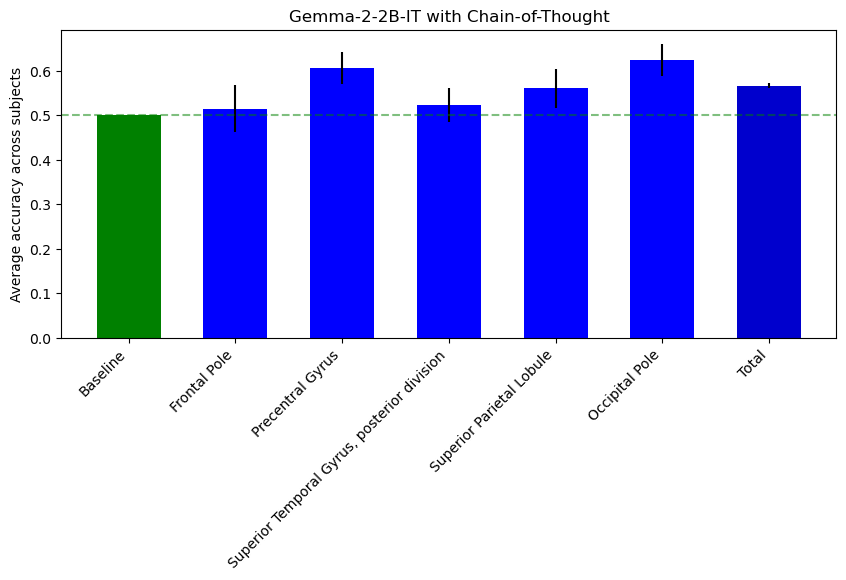

In [22]:
# Retrieve the average accuracy across subjects, and the standard error of the accuracy across subjects. 
accuracy_mean = list(accuracy_summary_gemma_CoT.mean().values)
accuracy_mean.insert(0, 0.5) # Insert a baseline average of 0.5. 
accuracy_se = list(accuracy_summary_gemma_CoT.std().values / np.sqrt(len(subjects)))
accuracy_se.insert(0, 0) # Insert a baseline standard error of 0. 

# Append the total average accuracy and its standard error. 
nb_brain_regions = accuracy_summary_gemma_CoT.shape[1]
accuracy_mean.append(np.mean(accuracy_mean[1:]))
accuracy_se.append(np.std(accuracy_mean[1:]) / (np.sqrt(len(subjects) * nb_brain_regions)))

# Create the labels. 
labels = brain_regions.copy()
labels.insert(0, 'Baseline')
labels.append('Total')

# Display the average accuracy and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 4))
axes.bar(range(nb_brain_regions + 2), accuracy_mean, width = 0.6, color = ['green', *['blue'] * nb_brain_regions, 'mediumblue'])
axes.errorbar(range(nb_brain_regions + 2), accuracy_mean, yerr = accuracy_se, fmt = 'None', color = 'black')
axes.axhline(accuracy_mean[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(nb_brain_regions + 2), labels = labels)
axes.set_xticklabels(labels, rotation = 45, ha = 'right')
axes.set_ylabel('Average accuracy across subjects')
axes.set_title('Gemma-2-2B-IT with Chain-of-Thought');

## **3. Results**

We save the results in the appropriate directory. 

In [23]:
# Save the results into a Pickle file. 
with open(results_path + 'classification/accuracy_summary_gemma_CoT.p', 'wb') as file:
    pickle.dump(accuracy_summary_gemma_CoT, file)